In [1]:
from pathflowai.utils import load_sql_df
import torch
import os 
import sys, os
sys.path.insert(0,"/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/")
os.environ['CUDA_VISIBLE_DEVICES']="0"
# import umap, numba
from sklearn.preprocessing import LabelEncoder
from torch_cluster import knn_graph
from torch_geometric.data import Data 
import numpy as np
from torch_geometric.utils import train_test_split_edges
import os
import argparse
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset,DataLoader
import os,glob, pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import pickle
import fire
import torch_geometric
import torch
import scipy.sparse as sps
from torch_cluster import radius_graph
from torch_geometric.utils import subgraph
from collections import Counter

nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [2]:
# TODO: ADD CONNECTED COMPONENTS!!!!!

In [2]:


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root=None, transform=None, pre_transform=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = None,None#torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        pass

    @property
    def processed_file_names(self):
        pass

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def process(self):
        # Read data into huge `Data` list.
        data_list = extract_graphs()

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


        
def get_graph_datasets(embedding_dir,k=8,radius=0,build_connected_components=False,min_component_size=600):
    embeddings={os.path.basename(f).split('.')[0]: torch.load(f) for f in glob.glob("{}/*.pkl".format(embedding_dir))}
    embeddings=dict(embeddings=np.vstack([embeddings[k]['embeddings'] for k in embeddings]),
               patch_info=pd.concat([embeddings[k]['patch_info'] for k in embeddings]))
    df=embeddings['patch_info'].iloc[:,2:].reset_index()
    z=pd.DataFrame(embeddings['embeddings']).loc[df.index]
    embeddings['patch_info']=df
    le=LabelEncoder()
    cols=df['annotation'].value_counts().index.tolist()
    cols=np.array(cols)
    le=le.fit(cols)
    df['y_true']=le.transform(cols[df[cols].values.argmax(1)])
    weights=compute_class_weight('balanced',sorted(df['y_true'].unique()),df['y_true'].values)

    def get_dataset(slide,k=8,radius=0,build_connected_components=False,min_component_size=600):
        xy=embeddings['patch_info'][embeddings['patch_info']['ID']==slide][['x','y']]
        xy=torch.tensor(xy.values).float().cuda()
        X=z[embeddings['patch_info']['ID'].values==slide]
        X=torch.tensor(X.values)
        y=torch.tensor(df.loc[embeddings['patch_info']['ID'].values==slide,'y_true'].values)
        if not radius:
            G=knn_graph(xy,k=k)
        else:
            G=radius_graph(xy, r=radius*np.sqrt(2), batch=None, loop=True)
        G=G.detach().cpu()
        G=torch_geometric.utils.add_remaining_self_loops(G)[0]
        xy=xy.detach().cpu()
        datasets=[]
        if build_connected_components:
            edges=G.detach().cpu().numpy().astype(int)
            n_components,components=list(sps.csgraph.connected_components(sps.coo_matrix((np.ones_like(edges[0]),(edges[0],edges[1])))))
            comp_count=Counter(components)
            components=torch.LongTensor(components)
            for i in range(n_components):
                if comp_count[i]>=min_component_size:
                    G_new=subgraph(components==i,G,relabel_nodes=True)[0]
                    xy_new=xy[components==i]
                    X_new=X[components==i]
                    y_new=y[components==i]
                    np.random.seed(42)
                    idx=np.arange(X_new.shape[0])
                    idx2=np.arange(X_new.shape[0])
                    np.random.shuffle(idx)
                    train_idx,val_idx,test_idx=torch.tensor(np.isin(idx2,idx[:int(0.8*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.8*len(idx)):int(0.9*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.9*len(idx)):]))
                    dataset=Data(x=X_new, edge_index=G_new, edge_attr=None, y=y_new, pos=xy_new)
                    dataset.train_mask=train_idx
                    dataset.val_mask=val_idx
                    dataset.test_mask=test_idx
                    dataset.id=slide
                    datasets.append(dataset)
            components=components.numpy()
                
        else:
            components=np.ones(X.shape[0])
            np.random.seed(42)
            idx=np.arange(X.shape[0])
            idx2=np.arange(X.shape[0])
            np.random.shuffle(idx)
            train_idx,val_idx,test_idx=torch.tensor(np.isin(idx2,idx[:int(0.8*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.8*len(idx)):int(0.9*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.9*len(idx)):]))
            dataset=Data(x=X, edge_index=G, edge_attr=None, y=y, pos=xy)
            dataset.train_mask=train_idx
            dataset.val_mask=val_idx
            dataset.test_mask=test_idx
            datasets.append(dataset)
        return datasets,components


    def extract_graphs(df,k=8,radius=0,build_connected_components=False,min_component_size=600):
        graphs=[]
        if build_connected_components: df['component']=-1
        for slide in df['ID'].unique():
            if df.loc[df['ID']==slide,'y_true'].sum():
                G,components=get_dataset(slide,k,radius,build_connected_components)
                graphs.extend(G) 
                if build_connected_components: df.loc[df['ID']==slide,"component"]=components
        return graphs,df
    
    graph_dataset,df=extract_graphs(df,k,radius,build_connected_components,min_component_size)
    return dict(df=df,weight=weights,graph_dataset=graph_dataset)

def graph_extraction(embedding_dir,save_file='graph_dataset_test.pkl',k=8,radius=0,build_connected_components=False,min_component_size=600):
    graph_datasets=get_graph_datasets(embedding_dir,k,radius,build_connected_components,min_component_size)
    pickle.dump(graph_datasets,open(save_file,'wb'))

In [8]:
graph_datasets={}
for k in ['bcc','complete']:
    embedding_dir=f"{k}/imagenet_embeddings"
    out_dir=f"{k}/graph_datasets"
    os.makedirs(out_dir,exist_ok=True)
    graph_extraction(embedding_dir,save_file=f'{out_dir}/imagenet_graph_data.pkl')

In [5]:
graph_datasets={}
for k in ['bcc','complete']:
    embedding_dir=f"{k}/imagenet_embeddings_256"
    out_dir=f"{k}/graph_datasets"
    os.makedirs(out_dir,exist_ok=True)
    graph_extraction(embedding_dir,save_file=f'{out_dir}/imagenet_graph_data_256_new.pkl',radius=256,build_connected_components=True)
    
    

In [9]:
# ! mv bcc/graph_datasets/imagenet_graph_data_256_update.pkl bcc/graph_datasets/pretrain_graph_data_256.pkl 

In [6]:
graph_datasets={}
for k in ['bcc']:
    embedding_dir=f"{k}/embeddings_pretrain"
    out_dir=f"{k}/graph_datasets"
    os.makedirs(out_dir,exist_ok=True)
    graph_extraction(embedding_dir,save_file=f'{out_dir}/pretrain_graph_data_256.pkl',radius=256,build_connected_components=True)
    
    

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning:

Pass classes=[0, 1], y=[1 1 1 ... 0 0 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error



In [10]:
def extract_region(arr,xmin,xmax,ymin,ymax):
    arr2=np.load(arr,mmap_mode="r")
    print(arr2.shape)
    return arr2[xmin:xmax,ymin:ymax]
    

In [11]:
import pickle
import numpy as np
import cv2
graph_datasets=pickle.load(open("bcc/graph_datasets/pretrain_graph_data_256.pkl",'rb'))

# arrays={ID:(lambda xmin,xmax,ymin,ymax: extract_region(f"bcc/inputs/{ID}.npy",xmin,xmax,ymin,ymax)) for ID in graph_datasets['df']['ID'].unique()}#np.load(f"bcc/inputs/{ID}.npy")



In [18]:
arrays["88_A1a"](100,200,200,300).shape

(100, 100, 3)

In [43]:
arrays["75_A1a"](25856,37632,44800,60160)

(22955, 83188, 3)


array([], shape=(0, 15360, 3), dtype=uint8)

In [44]:
np.load("bcc/inputs/75_A1a.npy",mmap_mode="r").shape#[25856:37632, 44800:60160].shape

(38914, 85168, 3)

In [12]:
thumbnails=[x.id for x in graph_datasets['graph_dataset']]
IDs=set(thumbnails)

for ID in IDs:
    arr=np.load(f"bcc/inputs/{ID}.npy")
    print(arr.shape)
    for i,graph in enumerate(graph_datasets['graph_dataset']):
        if thumbnails[i]==ID:
            xmin,ymin,xmax,ymax=np.hstack([graph.pos.min(0).values.numpy(),graph.pos.max(0).values.numpy()]).astype(int)
            arr2=arr[xmin:xmax,ymin:ymax,:]
            thumbnails[i]=cv2.resize(arr2,None,fx=1/16,fy=1/16,interpolation=cv2.INTER_CUBIC)
            del arr2
    del arr


# for i,graph in enumerate(graph_datasets['graph_dataset']):
#     xmin,ymin,xmax,ymax=np.hstack([graph.pos.min(0).values.numpy(),graph.pos.max(0).values.numpy()]).astype(int)
    
#     arr=np.array(arrays[graph.id](xmin,xmax,ymin,ymax))#arrays[graph.id][xmin:xmax,ymin:ymax,:]#np.load(f"bcc/inputs/{graph.id}.npy",mmap_mode="r")
#     print(graph.id,xmin,xmax,ymin,ymax,arr.shape)
#     thumbnails.append(cv2.resize(arr,None,fx=1/16,fy=1/16,interpolation=cv2.INTER_CUBIC))
    
    
# pickle.dump(graph_datasets,open("bcc/graph_datasets/imagenet_graph_data_256_new.pkl",'wb'))
# pickle.dump(thumbnails,open("bcc/image_thumbnails_new.pkl",'wb'))
pickle.dump(thumbnails,open("bcc/pretrain_image_thumbnails_new.pkl",'wb'))



(26762, 79226, 3)
(36215, 84215, 3)


/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



(28678, 93091, 3)
(43682, 71304, 3)
(16757, 80298, 3)
(39222, 76382, 3)
(27582, 55458, 3)
(23841, 85168, 3)
(39075, 81207, 3)
(27321, 47536, 3)
(32224, 89130, 3)
(25695, 79226, 3)
(36818, 85168, 3)
(24094, 86173, 3)
(34077, 77246, 3)
(25695, 79226, 3)
(42056, 60713, 3)
(27249, 79226, 3)
(22442, 89130, 3)
(19891, 71304, 3)
(27066, 95966, 3)
(32787, 60713, 3)
(39558, 78339, 3)
(17393, 85168, 3)
(25624, 89130, 3)
(24083, 82256, 3)
(33756, 95072, 3)
(32708, 86173, 3)
(33111, 89130, 3)
(30118, 57439, 3)
(37947, 95966, 3)
(23439, 89130, 3)
(25856, 81207, 3)
(46007, 91110, 3)
(31369, 53478, 3)
(26421, 90090, 3)
(28472, 45555, 3)
(27020, 65362, 3)
(24558, 78339, 3)
(24083, 82256, 3)
(27146, 85168, 3)
(19488, 71304, 3)
(33315, 91110, 3)
(22955, 83188, 3)
(30047, 73284, 3)
(38752, 83188, 3)
(34803, 79226, 3)
(41090, 97925, 3)
(38108, 87149, 3)
(22442, 89130, 3)
(30771, 91110, 3)
(38914, 85168, 3)
(40454, 89130, 3)
(26548, 51497, 3)
(24895, 77246, 3)
(32465, 76382, 3)
(28124, 49517, 3)
(24486, 74

In [ ]:
import pickle
thumbnails=pickle.load(open("bcc/image_thumbnails_new.pkl",'rb'))

In [1]:
! ls -lah bcc/image_thumbnails_new.pkl

-rwxrwx--- 1 f003k8w rc-VaickusL_slow-admin 736M Aug 22 01:24 bcc/image_thumbnails_new.pkl


In [35]:
import matplotlib,matplotlib.pyplot as plt
%matplotlib inline
# plt.imshow(arr)


(11776, 15360, 3)

In [68]:
embedding_dir="bcc/imagenet_embeddings_256/"
embeddings={os.path.basename(f).split('.')[0]: torch.load(f) for f in glob.glob("{}/*.pkl".format(embedding_dir))[:2]}
embeddings=dict(embeddings=np.vstack([embeddings[k]['embeddings'] for k in embeddings]),
           patch_info=pd.concat([embeddings[k]['patch_info'] for k in embeddings]))

In [66]:
(embeddings['patch_info']['ID']=='88_A1a').values#.unique()

array([False, False, False, ..., False, False, False])

In [91]:
ID="88_A1a"

In [100]:
from sklearn.decomposition import PCA
from umap import UMAP
Z=UMAP(n_components=2).fit_transform(embeddings['embeddings'][(embeddings['patch_info']['ID']==ID).values])


/home/anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 2 separate connected components using meta-embedding (experimental)



In [105]:
# plt.scatter(Z[:,0],Z[:,1],c=embeddings['patch_info'][(embeddings['patch_info']['annotation']=="BCC").values]['BCC'],alpha=0.5)

In [89]:
from sklearn.preprocessing import LabelEncoder
y=LabelEncoder().fit_transform(embeddings['patch_info']['annotation'][(embeddings['patch_info']['ID']==ID).values])




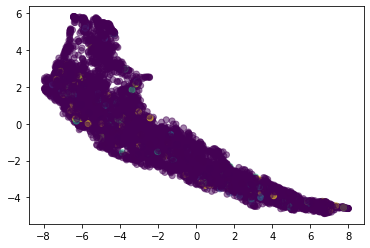

In [90]:
import matplotlib,matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(Z[:,0],Z[:,1],c=embeddings['patch_info'][(embeddings['patch_info']['ID']==ID).values]['BCC'],alpha=0.5)

In [84]:
arr=np.load(f"bcc/inputs/{ID}.npy",mmap_mode="r+")

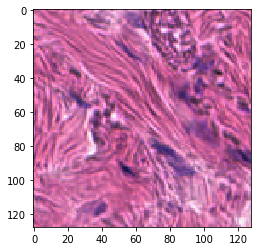

In [73]:
x,y=7936,7680
plt.imshow(arr[x-64:x+64,y-64:y+64])

(-3238.4003942652334,
 84902.40039426523,
 -17395.200607064016,
 -780.7993929359824)

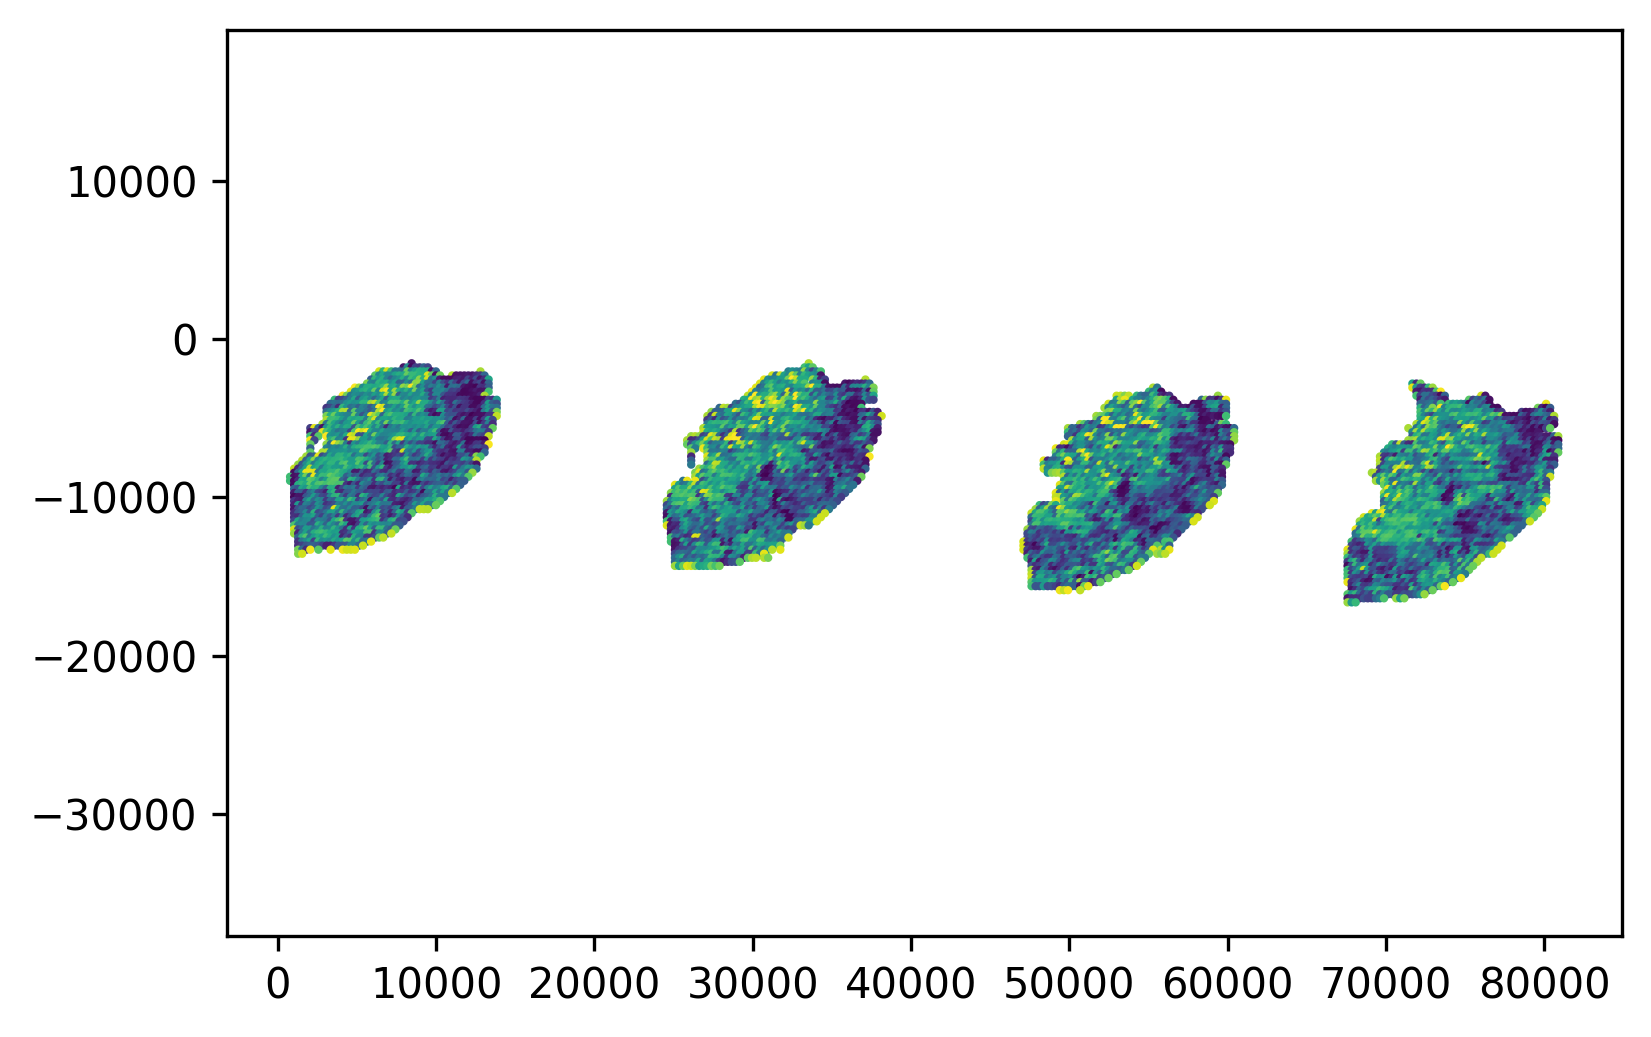

In [92]:
matplotlib.rcParams['figure.dpi']=300

plt.scatter(embeddings['patch_info']['y'][embeddings['patch_info']['ID']==ID],-embeddings['patch_info']['x'][embeddings['patch_info']['ID']==ID],c=Z[:,1],s=1)
plt.axis('equal')



(-3238.4003942652334,
 84902.40039426523,
 -17395.200607064016,
 -780.7993929359824)

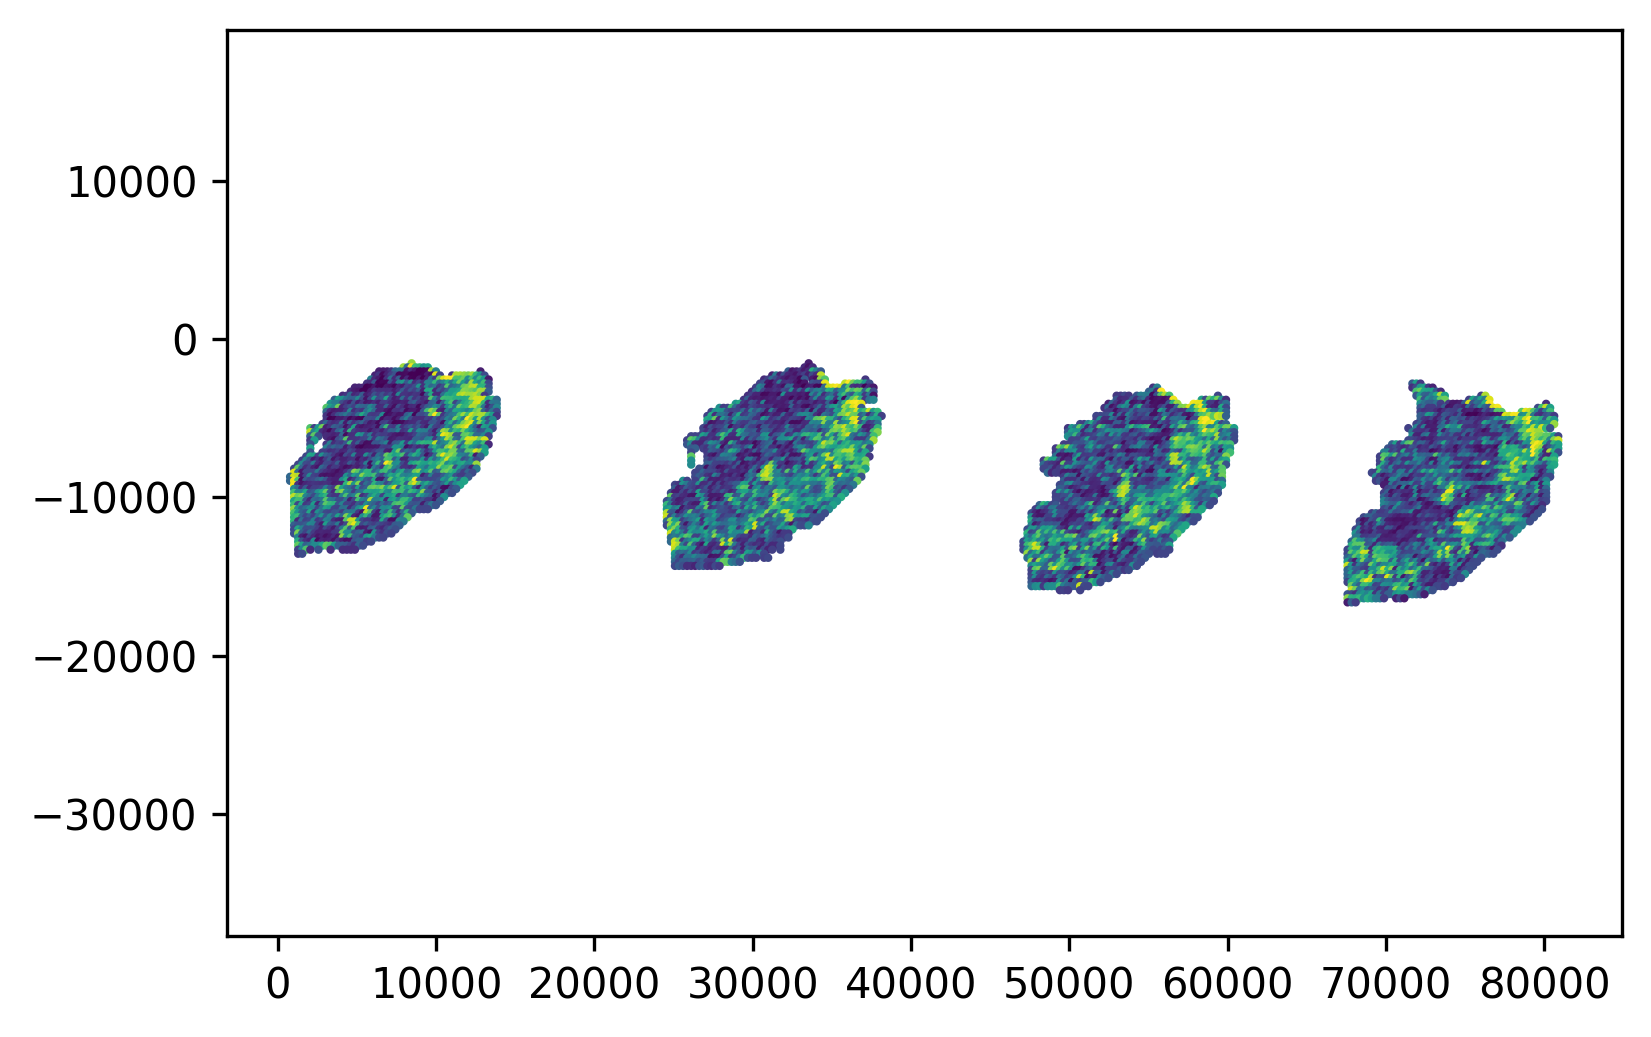

In [94]:
matplotlib.rcParams['figure.dpi']=300

plt.scatter(embeddings['patch_info']['y'][embeddings['patch_info']['ID']==ID],-embeddings['patch_info']['x'][embeddings['patch_info']['ID']==ID],c=Z[:,0],s=1)

plt.axis('equal')



(-3238.4003942652334,
 84902.40039426523,
 -17395.200607064016,
 -780.7993929359824)

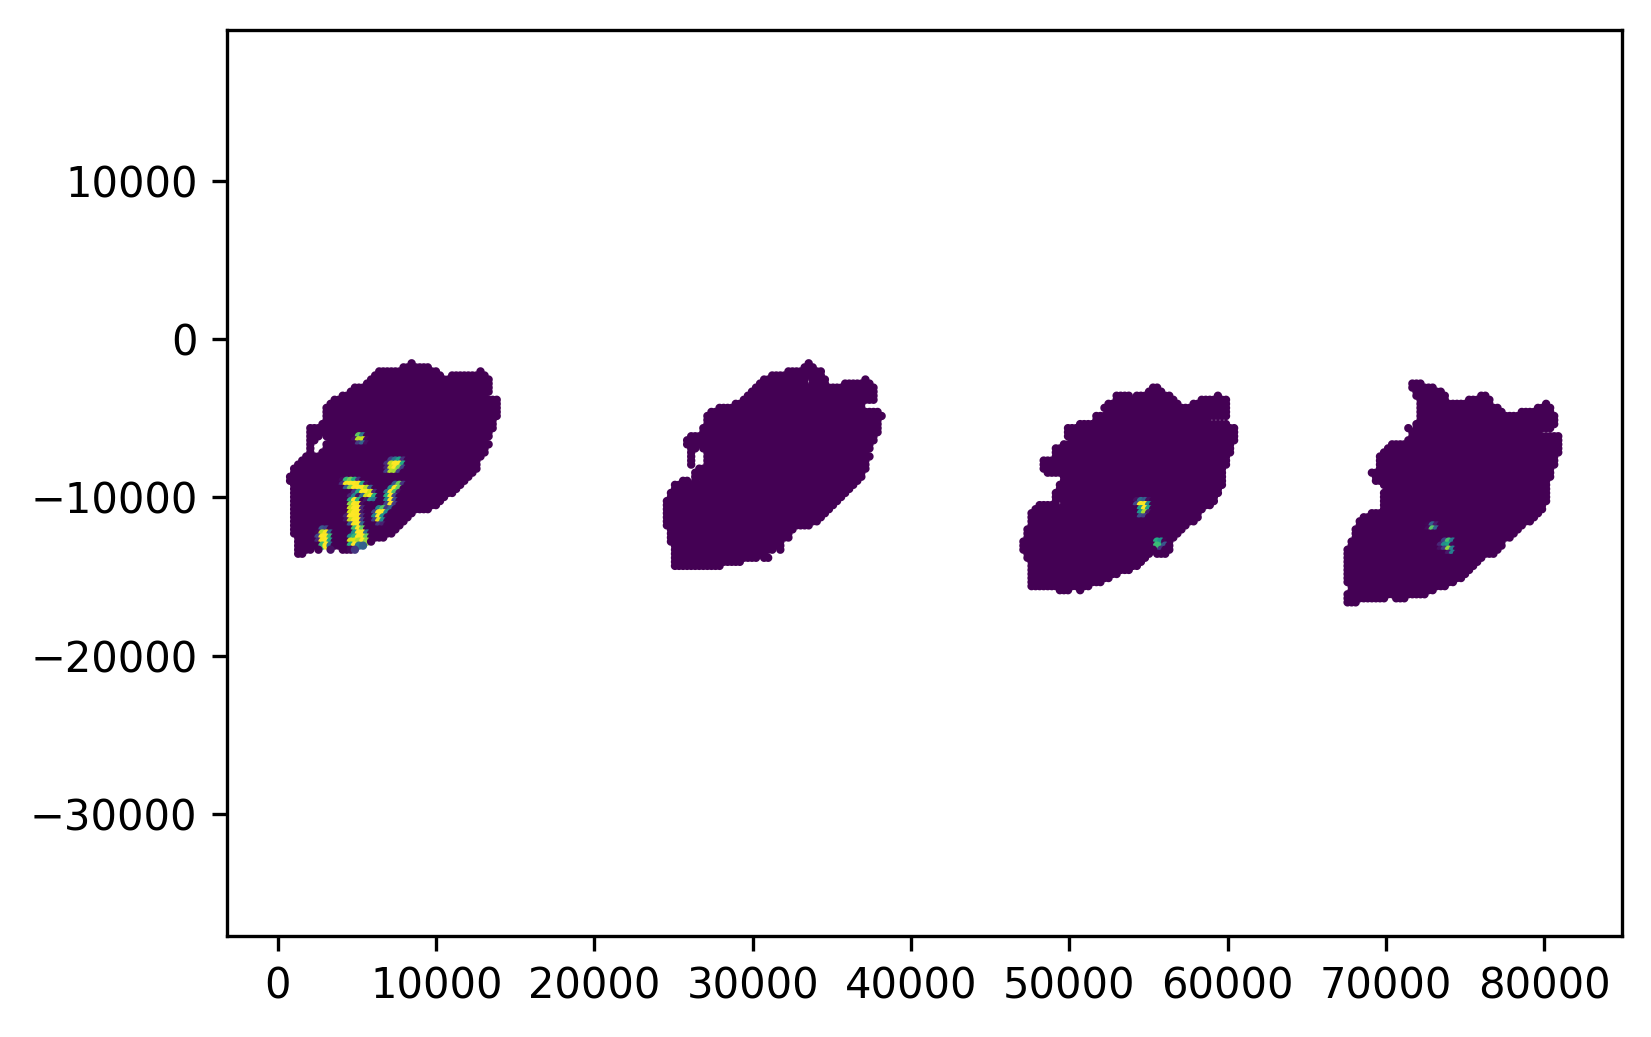

In [95]:
plt.scatter(embeddings['patch_info']['y'][embeddings['patch_info']['ID']==ID],-embeddings['patch_info']['x'][embeddings['patch_info']['ID']==ID],c=embeddings['patch_info']['BCC'][embeddings['patch_info']['ID']==ID],s=1)
plt.axis('equal')


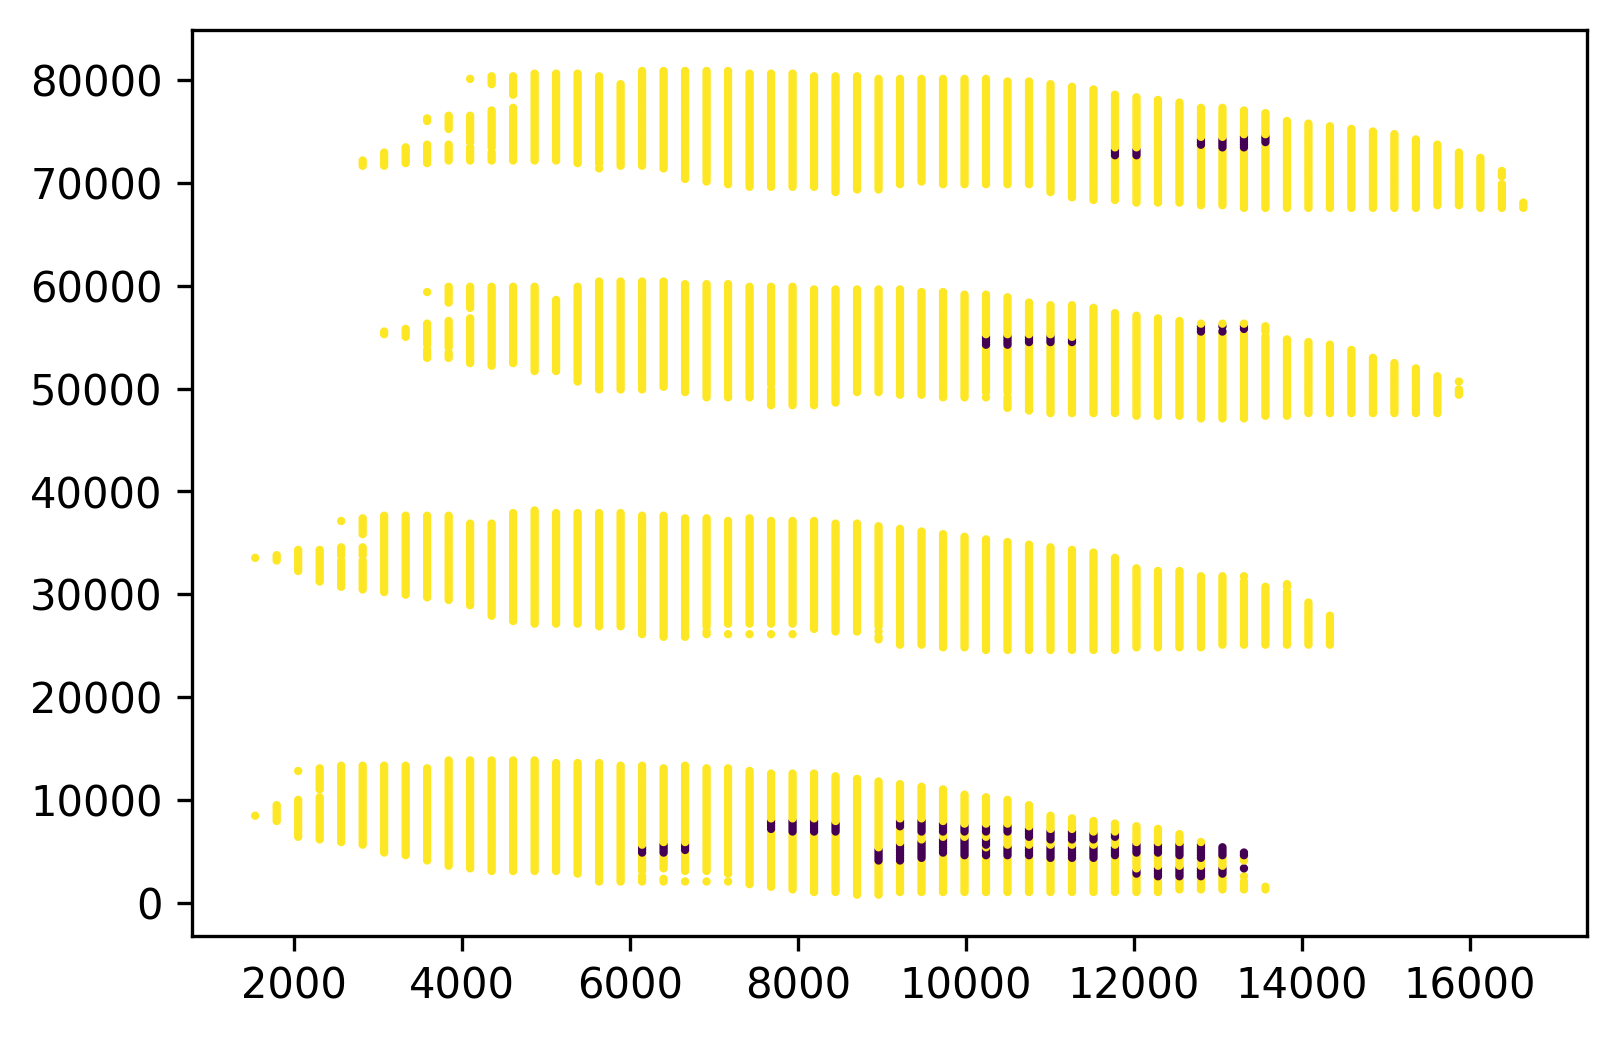

In [96]:
matplotlib.rcParams['figure.dpi']=300
y=LabelEncoder().fit_transform(embeddings['patch_info']['annotation'][embeddings['patch_info']['ID']==ID])
plt.scatter(embeddings['patch_info']['x'][embeddings['patch_info']['ID']==ID],embeddings['patch_info']['y'][embeddings['patch_info']['ID']==ID],c=y,s=1)



In [26]:
embeddings['patch_info'][embeddings['patch_info']['annotation']=='BCC']

,level_0,index,ID,x,y,patch_size,annotation,Blue_Ink,BCC,Nerve,Eccrine_Gland,Red_Ink,Hair_Follicle,Sebaceous_Gland,Inflammation,Benign
1723,379810,7795,88_A1a,6144,4864,256,BCC,0.0,0.000322,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1724,379811,7796,88_A1a,6144,5120,256,BCC,0.0,0.749173,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1725,379812,7797,88_A1a,6144,5376,256,BCC,0.0,0.389933,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1890,379977,8119,88_A1a,6400,4864,256,BCC,0.0,0.034136,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1891,379978,8120,88_A1a,6400,5120,256,BCC,0.0,0.893219,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1892,379979,8121,88_A1a,6400,5376,256,BCC,0.0,0.922346,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1893,379980,8122,88_A1a,6400,5632,256,BCC,0.0,0.020206,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2058,380145,8444,88_A1a,6656,5120,256,BCC,0.0,0.160895,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2059,380146,8445,88_A1a,6656,5376,256,BCC,0.0,0.309382,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2060,380147,8446,88_A1a,6656,5632,256,BCC,0.0,0.032026,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
import torch
import scipy.sparse as sps
from torch_cluster import radius_graph
from torch_geometric.utils import subgraph
embeddings['patch_info']['subgraph']=''

xy=torch.tensor(embeddings['patch_info'][embeddings['patch_info']['ID']==ID][['x','y']].values).cuda().float()

edge_index = radius_graph(xy, r=256*np.sqrt(2), batch=None, loop=True)

edges=edge_index.detach().cpu().numpy().astype(int)
n_components,components=list(sps.csgraph.connected_components(sps.coo_matrix((np.ones_like(edges[0]),(edges[0],edges[1])))))
components=torch.LongTensor(components).cuda()

for i in range(n_components):
    G=subgraph(components==i,edge_index,relabel_nodes=True)[0]
    xy_new=xy[components==i]
    
    embeddings['patch_info']['subgraph']=i
    

<6900x6900 sparse matrix of type '<class 'numpy.int64'>'
	with 59658 stored elements in COOrdinate format>

In [ ]:
# update df, xy

In [140]:

#     X_new=